## 以TF-IDF 分析 三立(Green) 與 TVBS(Blue) 對韓國瑜的看法

In [418]:
from collections import Counter
import jieba
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import sys
sys.path.insert(0, '../modules/')

from fintextmin import *  # 使用 modules 中的 fintextmin 模組

In [419]:
blue_text_list = read_text_folder('data/blue/')
green_text_list = read_text_folder('data/green/')

print("documents count: blue({}), green({})".format(len(blue_text_list), len(green_text_list)))

documents count: blue(3), green(3)


### 製作詞頻矩陣

下面以 Python 實現製作詞頻矩陣的步驟，並附上對應的fintextmin函式

In [420]:
stopwords = []

# dwc = document word count
blue_dwc = count_words_in_documents(doc_list = blue_text_list,
                               doc_names = range(len(blue_text_list)),
                               stopwords = stopwords)

green_dwc = count_words_in_documents(doc_list = green_text_list,
                               doc_names = range(len(green_text_list)),
                               stopwords = stopwords)

In [431]:
def create_doc_word_freq_dict(dwc):
    """ Create word frequency dict from the specified documents list """
    return {key: {i:Counter(doc)[i] for i in Counter(doc) if len(i) >= 2} for key, doc in dwc.items()}

blue_doc_word_frequency = create_doc_word_freq_dict(blue_dwc)
green_doc_word_frequency = create_doc_word_freq_dict(green_dwc)

#list(blue_doc_word_frequency[0].items())[0:10]
list(green_doc_word_frequency[0].items())[0:10]

[('政治', 3),
 ('中心', 1),
 ('綜合', 1),
 ('報導', 1),
 ('合一', 1),
 ('選舉', 1),
 ('進入', 1),
 ('數階段', 1),
 ('高雄', 3),
 ('選戰備', 1)]

In [432]:
def create_wfm(doc_word_frequency: dict):
    """ Create word frequency matrix from the specified word frequency dict """
    dwf_list = [pd.DataFrame(list(doc.values()), index=doc.keys()) for doc in doc_word_frequency.values()]
    wfm = pd.concat(dwf_list, axis=1)
    wfm = np.transpose(wfm).fillna(0)
    wfm.index = doc_word_frequency.keys()

    puncs = set_puncs() # 因為一開始沒有清除標點符號,這邊回過頭來將它們自矩陣移除
    return wfm[list(set(wfm) - set(puncs))]

# word frequency matrices
blue_wfm = create_wfm(blue_doc_word_frequency)
green_wfm = create_wfm(green_doc_word_frequency)

#blue_wfm
green_wfm

/home/aesophor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


,互相,紛紛,當然,政壇,東豪,口出狂言,壓迫,大批,作為,藍綠,...,是講,親中,有陳情,訪態度,特別,數階段,要求,方面,此番,進入
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,2.0,1.0,0.0,0.0,7.0,0.0,1.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


### TF-IDF（最簡單的詞頻分析方法）進行矩陣轉換

某一文件內的高頻率詞語，以及該詞語在整個 **corpus** (文件集合) 中的低文件頻率，可以產生出高權重的TF-IDF。

因此，TF-IDF傾向於過濾掉常見的詞語，保留重要的詞語。

> TF: 該詞在文件y 中的出現次數 / 在文件y 中所有字詞的出現次數和
> 
> IDF: log( 語料庫中的文件總數 / 包含詞語x 的文件數目 )

![50%](https://1.bp.blogspot.com/-tnzPA6dDtTU/Vw6EWm_PjCI/AAAAAAABDwI/JatHtUJb4fsce9E-Ns5t02_nakFtGrsugCLcB/s1600/%25E8%259E%25A2%25E5%25B9%2595%25E5%25BF%25AB%25E7%2585%25A7%2B2016-04-14%2B%25E4%25B8%258A%25E5%258D%25881.39.07.png)

In [433]:
# tf(x,y) = frequency of term x in document y.

def create_tfm(wfm):
    tfm = wfm.copy()
    for i in range(0, len(tfm)):
        tfm.iloc[i] = tfm.iloc[i] / tfm.iloc[i].sum()
    return tfm

blue_tfm = create_tfm(blue_wfm)
green_tfm = create_tfm(green_wfm)

green_tfm

,互相,紛紛,當然,政壇,東豪,口出狂言,壓迫,大批,作為,藍綠,...,是講,親中,有陳情,訪態度,特別,數階段,要求,方面,此番,進入
0,0.000000,0.000000,0.007519,0.000000,0.000000,0.007519,0.000000,0.007519,0.000000,0.000000,...,0.000000,0.000000,0.007519,0.007519,0.000000,0.007519,0.000000,0.000000,0.007519,0.007519
1,0.000000,0.000000,0.000000,0.007519,0.000000,0.000000,0.000000,0.000000,0.007519,0.000000,...,0.007519,0.007519,0.000000,0.000000,0.007519,0.000000,0.007519,0.000000,0.000000,0.000000
2,0.014493,0.007246,0.000000,0.000000,0.050725,0.000000,0.007246,0.000000,0.000000,0.014493,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007246,0.000000,0.007246


In [430]:
# df(x) = number of documents containing term x
blue_df = (blue_wfm >= 1).sum()
green_df = (green_wfm >= 1).sum()

green_df[0:10]

互相      1
紛紛      1
當然      1
政壇      1
東豪      1
口出狂言    1
壓迫      1
大批      1
作為      1
藍綠      1
dtype: int64

In [425]:
# N = total number of documents.
N = len(text_list)
N

8

In [436]:
# Calculate TF-IDF

def create_tfidfm(tfm, N, df):
    tfidfm = tfm.copy()
    for i in range(0, len(tfidfm)):
        tfidfm.iloc[i] = tfidfm.iloc[i] * np.log10(N / df)
    return tfidfm
    
blue_tfidfm = create_tfidfm(blue_tfm, N, blue_df)
green_tfidfm = create_tfidfm(green_tfm, N, green_df)

green_tfidfm['韓國瑜']

0    0.025622
1    0.022419
2    0.012347
Name: 韓國瑜, dtype: float64

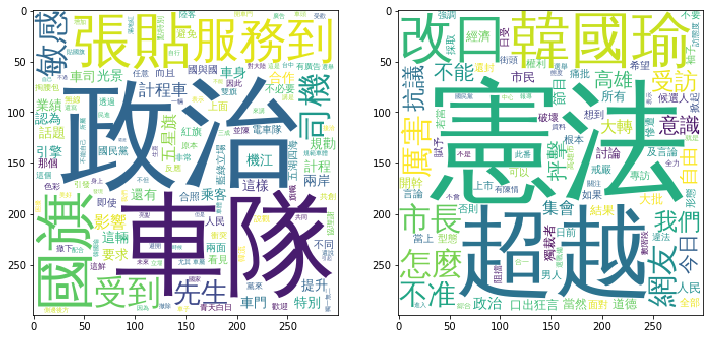

In [435]:
linux_font = r'/usr/share/fonts/wqy-zenhei/wqy-zenhei.ttc'

plt.figure(figsize=(12, 6))

# TVBS (Blue)
ax1 = plt.subplot(121)
plot_tfidf_wordcloud(blue_tfidfm, text_index=0, ax=ax1, font_path=linux_font, height=300, width=300)

# 三立 (Green)
ax2 = plt.subplot(122)
plot_tfidf_wordcloud(green_tfidfm, text_index=0, ax=ax2, font_path=linux_font, height=300, width=300)